In [85]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

In [86]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform = None):
        super().__init__()
        self.images_dir = image_dir
        self.annotations_dir = annotation_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, index):
        image = Image.open(self.images_dir[index]).convert('RGB')
        bbox, label = self.parse_annotation(self.annotations_dir[index])
        
        if self.transform != None:
            image = self.transform(image)

        return image, label, bbox

    
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)

        # Khởi tạo label
        label = None
        bbox = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None:
                label = name

            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            # Normalize bbox coordinates to [0, 1]
            bbox = [
                xmin / image_width,
                ymin / image_height,
                xmax / image_width,
                ymax / image_height,
            ]

        bbox_tensor = torch.tensor(bbox, dtype=torch.float32)
        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        return bbox_tensor, label_num

In [87]:
def get_count_filename_obj(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    count = 0

    for obj in root.findall('object'):
        count += 1
    return count


def filter_images_with_multiple_obj(images_path, annotations_paths):
        valid_img_paths = []
        valid_img_annotation_paths = []
        for index, annotation_path in enumerate(annotations_paths):
            count = get_count_filename_obj(annotation_path)
            if count <= 1:
                valid_img_paths.append(images_path[index])
                valid_img_annotation_paths.append(annotations_paths[index])
            else:
                print(
                    f"Image {images_path[index]} has multiple objects and will be excluded from the dataset")

        print(f"Total has {len(valid_img_paths)} valid image")

        return valid_img_paths, valid_img_annotation_paths

In [88]:
# Data directory
annotations_dir = './data/dog-and-cat-detection/annotations'
image_dir = './data/dog-and-cat-detection/images'

image_files = [os.path.join(image_dir, f) for f in os.listdir(
    image_dir) if os.path.isfile(os.path.join(image_dir, f))]
annotations_files = [os.path.join(annotations_dir, f) for f in os.listdir(
    annotations_dir) if os.path.isfile(os.path.join(annotations_dir, f))]

# filter image > 1 obj

image_files, annotations_files = filter_images_with_multiple_obj(image_files, annotations_files)

x_train, x_val, y_train, y_val = train_test_split(
    image_files, annotations_files, test_size=0.2, random_state=42)

# Output the result
print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))

y_train[0]

Image ./data/dog-and-cat-detection/images\Cats_Test736.png has multiple objects and will be excluded from the dataset
Total has 3685 valid image
Training set size: 2948
Validation set size: 737


'./data/dog-and-cat-detection/annotations\\Cats_Test19.xml'

In [89]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(x_train, y_train, transform=transform)
val_dataset = ImageDataset(x_val, y_val, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Labels: tensor([1, 0, 1, 0, 1, 1, 1, 1])


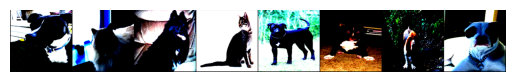

In [90]:
import matplotlib.pyplot as plt
import torchvision

# Hàm để hiển thị hình ảnh
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')  # Ẩn trục tọa độ
    plt.show()


# Lấy một batch từ train_loader và hiển thị ảnh
for i, (input_img, labels, bbox) in enumerate(train_loader, 0):
    print(f"Labels: {labels[:8]}")  # In nhãn của 8 ảnh đầu tiên
    # Hiển thị 8 ảnh đầu tiên
    imshow(torchvision.utils.make_grid(input_img[:8]))
    break  # Thoát khỏi vòng lặp sau batch đầu tiên

### Xây dựng model

In [91]:
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(
            *list(self.base_model.children())[:-1])
        self.num_classes = num_classes
        self.num_ftrs = self.base_model.fc.in_features

        self.classifier = nn.Linear(self.num_ftrs, num_classes)
        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)

        
    def forward(self, x):
        x = self.feature_extractor(x)
        # flatten từ trục 1 trở về sau
        x = torch.flatten(x, 1)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))

        return class_logits, bbox_coords

In [92]:
# Model
model = TwoHeadedModel(2)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion_classifier = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
print(model)

TwoHeadedModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [93]:
import matplotlib.pyplot as plt

def evaluate(model, val_loader, criterion_classifier, criterion_bbox, device):
    model.eval()
    losses_eval = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (image, label, bbox) in enumerate(val_loader):
            image = image.to(device)
            label = label.to(device)
            bbox = bbox.to(device)

            class_logits, bbox_coords = model(image)
            loss_classifier = criterion_classifier(class_logits, label)
            loss_bbox = criterion_bbox(bbox_coords, bbox)
            loss = loss_classifier + loss_bbox

            losses_eval.append(loss.item())

            _, predictions = class_logits.max(1)
            correct += (predictions == label).sum().item()
            total += label.size(0)

    accuracy = float(correct) / float(total) * 100
    avg_loss_eval = sum(losses_eval) / len(losses_eval)

    return avg_loss_eval, accuracy


best_accuracy = 0.0
best_model = None
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    losses_train = []
    model.train()
    for batch_idx, (image, label, bbox) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        bbox = bbox.to(device)

        class_logits, bbox_coords = model(image)
        loss_classifier = criterion_classifier(class_logits, label)
        loss_bbox = criterion_bbox(bbox_coords, bbox)
        loss = loss_classifier + loss_bbox

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())

    avg_loss_train = sum(losses_train) / len(losses_train)
    avg_loss_eval, accuracy = evaluate(
        model, val_loader, criterion_classifier, criterion_bbox, device)

    train_losses.append(avg_loss_train)
    val_losses.append(avg_loss_eval)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {avg_loss_train:.4f}, "
          f"Validation Loss: {avg_loss_eval:.4f}, "
          f"Validation Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()
        torch.save(best_model, './model/best_model_ex2.pth')
        print(f"New best model saved with accuracy: {best_accuracy:.2f}%")



KeyboardInterrupt: 

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))

# Loss Visualization
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Accuracy Visualization
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies,
         label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()